_What are is our hypothesis?_
1. Mortality rates will be different in areas of different treatment.
2. Mortality rates will be different over different landforms.
3. Recovery will occur at different rates on different landforms.
    a. Ridges and dryer slopes will recover more quickly than valleys under after severe fire?


_What do we know about the problem before observing any data?_  

_What conclusions can we draw from data given our prior knowledge?_

_Do these conclusions make sense?_


Joint density function of a tree being dead and a treatment:    
$p_{\theta}(\mathbf{x}, \mathbf{z}) = p_{\theta}(\mathbf{z})p(\mathbf{x}|\mathbf{z})$ 



In [383]:
from pathlib import Path
from joblib import Parallel, delayed
import textwrap

import pandas as pd
import geopandas as gpd
from tqdm import tqdm
import pyro
import pyro.distributions as dist
import pyro.distributions.constraints as constraints
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import warnings



In [367]:
warnings.filterwarnings('ignore')


## Load and prepare data
In this section we will read the stored predictions then draw $n$ samples from a _classification probability distribution_ for each of the $m$ crowns in the datset.  The mean of the prediction probability distribution will be the prediction probability from the RF model.  The standard deviation we be the value determined in `src/mortality_classification.ipynb`.  Once each crown has a classification probability distribution, they will be joined into an $m\times n$ array. 
$
[[x_{0\_0}, x_{0\_1}, ..., x_{0\_n}],\\
[x_{1\_1}, x_{1\_1}, ..., x_{1\_n}],\\
[\dots],\\
[x_{m\_1}, x_{m\_1}, ..., x_{m\_n}]]\\
$
where each row (of length $n$) corresponds to the observations for a single crown, and each column (of length $m$) corresponds to a _sample population_ of living and dead crowns.

In [3]:
# paths
helena_path = Path.cwd().parent / 'data' / 'helena'
pred_path = helena_path / 'predictions.parquet'
img_dir = Path('/home/michael/thesis/images')

# set seed for reproducibility
pyro.set_rng_seed(1234)

# function to return samples
def pred_model(μ, σ, sample_shape):
    return dist.Normal(μ, σ).sample(sample_shape=sample_shape)

In [4]:
# read the predictions to df, and add std column
pred_probs = gpd.read_parquet(pred_path).set_index('UniqueID')
pred_probs['sigma'] = 0.3348311848324811

In the cell below we define function to create populations of crowns, then summarize them by percentage of crowns which are dead. 

In [5]:
# processors for Parallel (-1 --> use all )
n_jobs = -1

def get_dead_percentages(samples, i):
    '''Returns percentage of crown predictions in colum i that are dead'''
    alive = (
        100
        * np.clip(samples, 0, 1).round().astype(int)[:, i].sum()
        / samples.shape[0]
    )
    
    return 100 - alive


def make_df_of_death(preds, draws=256):
    '''
    Returns Pandas DataFrame of percentages of crowns which are
    modeled as dead based the RF model predictions and sigma as
    found in mortality_clasification.ipynb.
    
    params:
        preds - Pandas DataFrame with prediction probabilities for each year.
        draws - Number of model draws to perform. 
    '''
    # get the names of columns containing predictions
    pred_cols = [c for c in preds.columns if 'pred_' in c]

    # sigma is the same for all
    sigma = torch.Tensor(preds.sigma.values)

    # empty df for results
    results = pd.DataFrame()

    for col in pred_cols:
        # get predictions as means
        mu = torch.Tensor(preds[col].values)
        
        # draw 256 samples per row
        samples = np.array(
            pred_model(
                mu,
                sigma,
                (draws,)
            )
        ).T
        
        dead_sums = Parallel(n_jobs=n_jobs)(
            delayed(get_dead_percentages)(samples, i)
            for i
            in range(samples.shape[1])
        )
        
        results[col.split('_')[1]] = dead_sums
        
    return results
        

In [6]:

dead = make_df_of_death(pred_probs)
dead.head()

,2018,2020,2022
0,48.628039,40.049266,59.408804
1,48.587341,40.310592,59.732248
2,48.557352,40.147799,59.869337
3,48.313163,40.094249,59.678698
4,48.251044,40.173503,59.515904


Each row in the DataFrame above contains an estimate for the percentage of crowns that are dead in each year corresponding to a sample population.

Text(0.5, 1.0, 'Percentage of Crowns Which Are Dead')

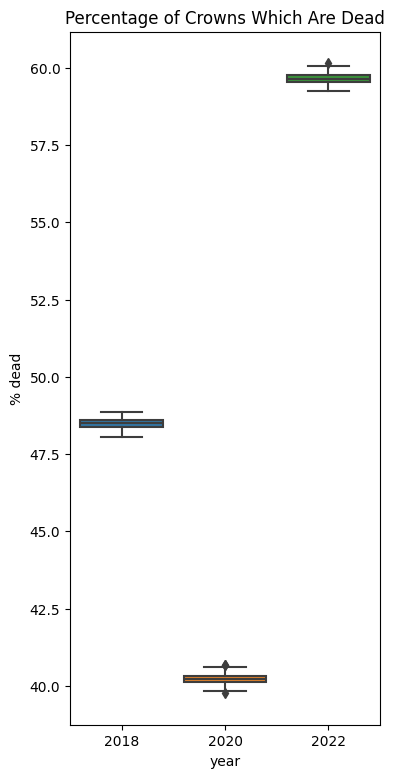

In [7]:
df_melted = dead.melt()
df_melted.columns = ['year', '% dead']
fig, ax = plt.subplots(1, 1, figsize=(4,9))
ax = sns.boxplot(
    data=df_melted,
    x='year',
    y='% dead',
)

ax.set_title('Percentage of Crowns Which Are Dead')

Boxplot showing the percentage of crowns which are dead for each year. Boxes show the distribution of results from populations (n=256) simulated using draws from the classification probability distributions of each crown.

In [135]:
def get_hdi(df, column_name, credible_mass=0.95):
    '''Returns credible interval bounds of df column.'''
    sorted_samples = np.sort(df[column_name].values)
    n_samples = len(sorted_samples)    
    # find index increment for credible mass
    ci_idx_inc = int(np.ceil(credible_mass * n_samples))
    # calculate the number of credible intervals
    n_ci = n_samples - ci_idx_inc
    # calculate width of each potential interval
    ci_width = sorted_samples[ci_idx_inc:] - sorted_samples[:n_ci]
    # find narrowest interval
    best_idx = np.argmin(ci_width)
    # get lower and upper bounds of credible interval
    hdi_min = sorted_samples[best_idx]
    hdi_max = sorted_samples[best_idx + ci_idx_inc]
    
    return hdi_min, hdi_max


In [9]:
dead['Annual Mortality 2018-2020'] = (dead['2018'] - dead['2020']) / 2
dead['Annual Mortality 2020-2022'] = (dead['2020'] - dead['2022']) / 2

credible_intervals = np.array([
    get_hdi(dead, col) for col in ['2018', '2020', '2022']
])

credible_intervals_mortality = np.array([
    get_hdi(dead, col) for col in ['Annual Mortality 2018-2020', 'Annual Mortality 2020-2022']
])

credible_lines_18_20 = dead[['2018', '2020']][
    (dead['Annual Mortality 2018-2020'] >=  credible_intervals_mortality[0, 0]) &
    (dead['Annual Mortality 2018-2020'] <=  credible_intervals_mortality[0, 1])
    ].T

credible_lines_20_22 = dead[['2020', '2022']][
    (dead['Annual Mortality 2020-2022'] >=  credible_intervals_mortality[1, 0]) &
    (dead['Annual Mortality 2020-2022'] <=  credible_intervals_mortality[1, 1])
    ].T



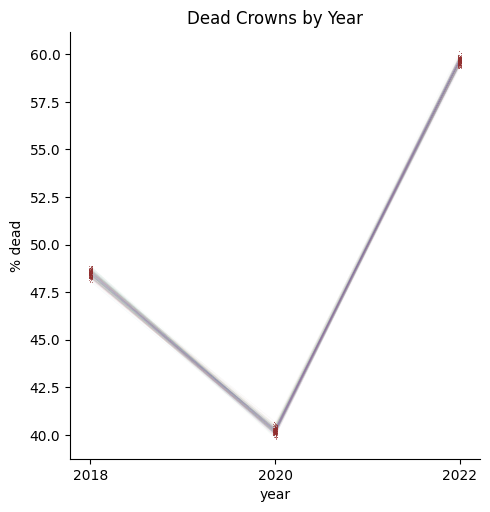

In [10]:
a = sns.catplot(
    data=df_melted,
    x='year',
    y='% dead',
    jitter=0.01,
    marker='.',
    size=1,
    color='r'
)

lw = 0.03

b = sns.lineplot(
    data=credible_lines_18_20,
    color='grey',
    linewidth=lw,
    alpha=0.5
)

c = sns.lineplot(
    data=credible_lines_20_22,
    color='grey',
    linewidth=lw,
    alpha=0.5
)

plt.legend('', frameon=False);
plt.title('Dead Crowns by Year')

plt.savefig(img_dir / 'helena_full_pop_scatter.png')

In [11]:
ci = credible_intervals.round(2)
cim = credible_intervals_mortality.round(2)



print(
    f'''
    Plot showing distributions of the percentages of crowns which are dead for each
    year (red points) and lines (grey) falling within the 95\% credible interval of annual mortality.
    The 95% credible intervals for percent of trees dead in: 2018$\\aprox${list(ci[0])},
    2020$\\aprox${list(ci[1])}, 2022$\\aprox${list(ci[2])}. The 95% credible intervals of annual
    mortality trends are: {cim[0]} for the period from 2018 to 2020, and {cim[1]} (recovery) for the period
    from 2020 to 2022. Data comes from the distribution of results from populations (n=256)
    simulated using draws from the classification probability distributions
    of each crown.
    '''
)



    Plot showing distributions of the percentages of crowns which are dead for each
    year (red points) and lines (grey) falling within the 95\% credible interval of annual mortality.
    The 95% credible intervals for percent of trees dead in: 2018$\aprox$[48.2, 48.85],
    2020$\aprox$[39.89, 40.51], 2022$\aprox$[59.31, 59.92]. The 95% credible intervals of annual
    mortality trends are: [3.93 4.39] for the period from 2018 to 2020, and [-9.93 -9.53] (recovery) for the period
    from 2020 to 2022. Data comes from the distribution of results from populations (n=256)
    simulated using draws from the classification probability distributions
    of each crown.
    


## Statistical difference between treatments.

+ find 95% credible interval for each treatment, landform, and treatment/landform
+ see if they overlap

This is a variation on permutatuion testing. See:
Cobb, George W. "The introductory statistics course: A Ptolemaic curriculum?." Technology innovations in statistics education 1.1 (2007).

### Make samples
In the cell below we make a dataframe containing 256 samples from the classification probability distribution of each crown. Each sample is an array of 0 or 1 integers denoting dead or living tree crowns.

In [12]:
#def pred_model():
    

def make_pop_df(preds, draws=256):
    '''
    Returns Pandas DataFrame of samples from crowns which are
    classified based the RF model predictions and sigma as
    found in mortality_clasification.ipynb.
    
    params:
        preds - Pandas DataFrame with prediction probabilities for each year.
        draws - Number of model draws to perform. 
    '''
    # make a df to return
    cols_dict = {
        c: preds[c]
        for c in[
            'treatment',
            'geomorph_100',
            'geomorph_250',
            'geomorph_500',
            'geomorph_1000',
            'geomorph_2000'
        ]
    }
    out_df = pd.DataFrame().assign(**cols_dict)
    
    # get the names of columns containing predictions
    pred_cols = [c for c in preds.columns if 'pred_' in c]

    # sigma is the same for all
    sigma = torch.Tensor(preds.sigma.values)

    for col in pred_cols:
        # get predictions as means
        mu = torch.Tensor(preds[col].values)
        
        # draw 256 per row
        sample = list(np.round(
            np.clip(
                np.array(
                    pred_model(
                        mu,
                        sigma,
                        (draws,)
                    ).T
                ),
                0,
                1
            )
            ).astype(int)
        )
        
        
        
        new_col = 'sample_' + col.split('_')[-1]
        out_df[new_col] = sample
        
    return out_df

# make sample df and check
sample_df = make_pop_df(pred_probs)   
print('sample_df.shape:', sample_df.shape)
print('sample shape:', sample_df.sample_2018.iloc[0].shape)
print('sample_df columns:')
_ = [print(f'\t{c}') for c in sample_df.columns]
print('sample_df index values(head):')
_ = [print(f'\t{i}') for i in sample_df.head().index]


sample_df.shape: (46685, 9)
sample shape: (256,)
sample_df columns:
	treatment
	geomorph_100
	geomorph_250
	geomorph_500
	geomorph_1000
	geomorph_2000
	sample_2018
	sample_2020
	sample_2022
sample_df index values(head):
	10N_483827_4524602
	10N_483828_4512551
	10N_483828_4514248
	10N_483829_4514263
	10N_483830_4510126


Alive and dead


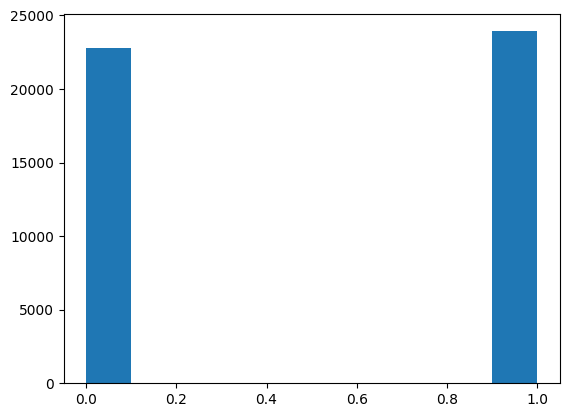

In [13]:
sample = np.stack(sample_df.sample_2018.values)[:, 0]
plt.hist(
    [sample]
    );

print('Alive and dead')

### Difference between treatments
Now we will look at histograms and find HDIs to determine difference between groups of crowns.

In [14]:
sample_df.treatment.unique()

array([ 3,  0, 12, 15])

In [17]:
def get_treatment_obs(y):
    '''Returns dict of treatment observations for year y.'''
    
    # dict mapping codes to meanings
    tr_codes = {
        0: 'unburned | unburned',
        3: 'unburned | high',
        12: 'high | unburned',
        15: 'high | high'
    }

    # empty dict for observations
    treatment_obs = {}
    # list of treatments
    treatments = list(tr_codes.keys())

    # get observations for all treatments
    all = np.stack(sample_df[f'sample_{y}'].values)
    treatment_obs['all treatments'] = Parallel(n_jobs=n_jobs)(
        delayed(get_dead_percentages)(all, i)
        for i
        in range(all.shape[1])
    )
    # get observations for each treatment
    for t in treatments:
        tr = np.stack(sample_df[sample_df.treatment == t][f'sample_{y}'].values)
        treatment_obs[tr_codes[t]] = Parallel(n_jobs=n_jobs)(
        delayed(get_dead_percentages)(tr, i)
        for i
        in range(tr.shape[1])
    )
        
    return treatment_obs


In [ ]:
years = ['2018', '2020', '2022']
dfs = []
# get the treatment observations
for y in years:
       treatment_obs = get_treatment_obs(y)
       df = pd.DataFrame.from_dict(treatment_obs)
       df['year'] = y
       dfs.append(df)

treatment_obs_df = pd.concat(dfs)

In [427]:
treatment_obs_df.head()

,all treatments,unburned | unburned,unburned | high,high | unburned,high | high,year
0,48.754418,24.496281,36.042213,81.244487,79.044279,2018
1,48.805826,24.543611,35.733011,81.807695,78.167470,2018
2,48.210346,23.989182,35.612019,80.416638,79.351162,2018
3,48.660169,24.327248,36.048935,81.271629,77.992109,2018
4,48.465246,24.171738,35.598575,81.081631,79.175800,2018



Shows mortality for each year for each treatment under consideration. All differences by year are significant, with the exception of 2018 and 2022 in the unburned | unburned treatment.

 Shows mortality for each year for each treatment under consideration. All
differences by year are significant, with the exception of 2018 and 2022 in
the unburned | unburned treatment.


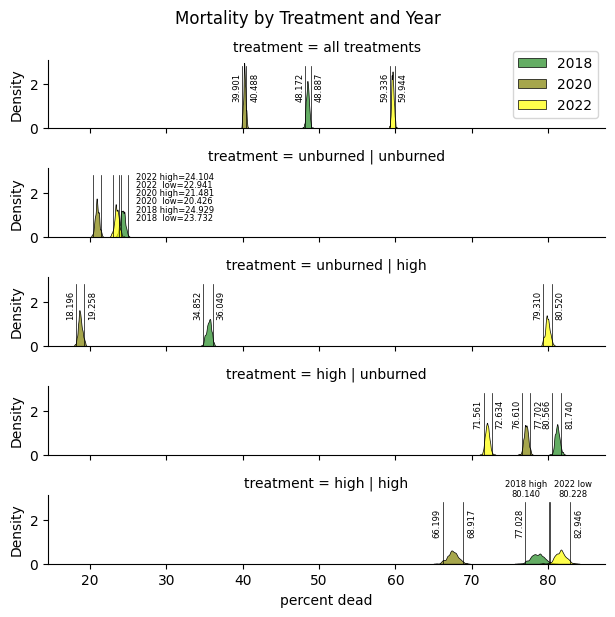

In [623]:
colors = {
        '2018': 'forestgreen',
        '2020': 'olive',
        '2022': 'yellow'
    }


def quasi_ridge_plot_w_hdi(obs_df, save_template):
       use = [c for c in obs_df.columns]# if c != 'all landforms']
       years = obs_df.year.unique().tolist()
       df = obs_df[use].melt(id_vars='year')
       df.columns = ['year', 'treatment', 'percent dead']
       d = {'color': [colors[c] for c in years]}
       rp = sns.FacetGrid(df, row='treatment', hue='year', hue_kws=d, aspect=5, height=1.25)
      
       rp.map(sns.kdeplot, 'percent dead', clip_on=False,
              shade=True, edgecolor='k', alpha=0.7, lw=0.5, bw=.2)

       axes = rp.axes.flatten()
       for ax in axes:
              col = ax.title.get_text().split(' = ')[-1]
              for i, year in enumerate(years):
                     low, high = get_hdi(obs_df[obs_df.year == year], col)
                     ax.axvline(low, ymax=0.9, lw=0.5, color='k')
                     ax.axvline(high, ymax=0.9, lw=0.5, color='k')
                     if col == 'unburned | unburned':
                            ax.annotate(f'{year}  low={low:.3f}', (26, 0.75 *(i+1)), fontsize=6)
                            ax.annotate(f'{year} high={high:.3f}', (26, 0.75 *(i+1) + 0.375), fontsize=6)
                     elif (col == 'high | high') & (year == '2022'):
                            ax.annotate(f'{year} low\n{low:.3f}', (low + 3, 3.05), fontsize=6, ha='center')
                            
                            ax.annotate(
                                   f'{high:.3f}',
                                   (high + 0.5, 1.3),
                                   fontsize=6,
                                   rotation=90
                                   )
                            
                     elif (col == 'high | high') & (year == '2018'):
                            ax.annotate(f'{low:.3f}', (low - 1.3, 1.3), fontsize=6, rotation=90)
                            
                            ax.annotate(
                                   f'{year} high\n{high:.3f}',
                                   (high - 3, 3.05),
                                   fontsize=6,
                                   ha='center'
                                   )

                     else:
                            ax.annotate(f'{low:.3f}', (low - 1.3, 1.3), fontsize=6, rotation=90)
                            ax.annotate(f'{high:.3f}', (high + 0.5, 1.3), fontsize=6, rotation=90)
       
       plt.legend(loc='upper right', bbox_to_anchor=(1, 7.6))
       rp.fig.subplots_adjust(top=0.9)
       rp.fig.suptitle(f'Mortality by Treatment and Year')   
       rp.fig.savefig(img_dir / f'{save_template}.png')   
        

quasi_ridge_plot_w_hdi(treatment_obs_df, 'treatment_x_year')

caption = '''
Shows mortality for each year for each treatment under consideration. All differences by year are significant, with the exception of 2018 and 2022 in the unburned | unburned treatment.
'''
print(caption)
print(textwrap.fill(caption, 75))

In [ ]:

caption = f'''
    Shows histograms of percent dead in simulated tree populations for the year 2018, 2020, and 2022. Panels: a, i, g) all treatments for the years 2018, 2020, and 2022 respectively; b) Closeup of treatments which were not burned in the 2017 Helena Fire, for 2018 with 95\% HDIs (\emph{{unburned | unburned}}: [{uu18[0]:.2f}, {uu18[1]:.2f}], \emph{{unburned | high}}:[{uh18[0]:.2f}, {uh18[1]:.2f}]); c) Closeup of the high severity treatments for 2018 with 95\% HDIs (\emph{{high | unburned}}: [{hu18[0]:.2f}, {hu18[1]:.2f}], \emph{{high | high}}:[{hh18[0]:.2f}, {hh18[1]:.2f}]); d) Closeup of treatments which were not burned in the 2017 Helena Fire, for 2020 with 95\% HDIs (\emph{{unburned | unburned}}: [{uu20[0]:.2f}, {uu20[1]:.2f}], \emph{{unburned | high}}:[{uh20[0]:.2f}, {uh20[1]:.2f}]); e)Closeup of the high severity treatments for 2020 with 95\% HDIs (\emph{{high | unburned}}: [{hu20[0]:.2f}, {hu20[1]:.2f}], \emph{{high | high}}:[{hh20[0]:.2f}, {hh20[1]:.2f}]); f) Closeup of the treatments which were burned severely in the 2021 Monument Fire,in 2022, with 95\% HDIs (\emph{{unburned | high}}: [{uh22[0]:.2f}, {uh22[1]:.2f}], \emph{{high | high}}:[{hh22[0]:.2f}, {hh22[1]:.2f}].
    
    Note, that in 2018, and 2020 the Monument fire had not yet happened, so for these years the \emph{{unburned | unburned}} treatment and the \emph{{unburned | high}} treatments, are equivalent to one another, as are the \emph{{unburned | unburned}} treatment and the \emph{{unburned | high}} treatments.  It is unexpected, given this fact, that the two unburned treatments are significantly different from one another (b, d), and the two high severity treatments are different from one another (c, e).
    '''

print('version for pasting to LaTeX document:')
print(caption)
print('\nVersion for reading here:')
print(textwrap.fill(caption, 75))


In [93]:
landforms = sample_df['geomorph_100'].unique().tolist()
landforms.sort()
landforms

[2, 3, 5, 6, 7, 9, 10]

![alt text](../img/r_geomorphon.png "Geomorphon codes")

In [187]:
def get_landform_obs(y, scale):
    '''
    Returns dict of landform observations for year, y, and scale.
    Remember, an observation is a percentage dead of a simulated population.
    '''
    # get landforms
    landforms = sample_df[f'geomorph_{scale}'].unique().tolist()
    landforms.sort()
    
    # dict to decode
    lf_codes = {
        1 : 'flat',
        2 : 'summit',
        3 : 'ridge',
        4 : 'shoulder',
        5 : 'spur',
        6 : 'slope',
        7 : 'hollow',
        8 : 'footslope',
        9 : 'valley',
        10: 'depression'
    }
     
    # empty dict for observations
    landform_obs = {}
    # columns with geomorphons of desired scale
    gm_col = [c for c in sample_df.columns if f'geomorph_{scale}' in c][0]
    
    # get observations for all landforms
    all = np.stack(sample_df[f'sample_{y}'].values)
    landform_obs['all landforms'] = Parallel(n_jobs=n_jobs)(
        delayed(get_dead_percentages)(all, i)
        for i
        in range(all.shape[1])
    )
    
    # get observations for each landform
    for l in landforms:
        lf = sample_df[sample_df[gm_col] == l][f'sample_{y}'].values
        if lf.shape[0] > 0:
            lf = np.stack(lf)
            landform_obs[lf_codes[l]] = Parallel(n_jobs=n_jobs)(
            delayed(get_dead_percentages)(lf, i)
            for i
            in range(lf.shape[1])
        )
        else:
            landform_obs[lf_codes[l]] = None
    return landform_obs


def find_hdi_spacing(obs_df):
    hdi_df = pd.DataFrame()
    for col in obs_df:
        hdi_df[col] = [get_hdi(obs_df, col)]
        
    hdi_df = hdi_df.T
    hdi_df['low'] = hdi_df[0].apply(lambda x: x[0])
    hdi_df['high'] = hdi_df[0].apply(lambda x: x[1])
    hdi_df = hdi_df.drop(0, axis=1)
    return hdi_df

In [263]:
colors = {
        'all landforms': 'fuchsia',
        'flat': 'forestgreen',
        'summit': 'maroon',
        'ridge': 'red',
        'shoulder': 'orange',
        'spur': 'goldenrod',
        'slope': 'yellow',
        'hollow': 'greenyellow',
        'footslope': 'cyan',
        'valley': 'blue',
        'depression': 'black'
    }

def hist_plot_ax(obs_dict, ax, bins=None):
    obs_df = pd.DataFrame.from_dict(obs_dict)
    hdi_df = find_hdi_spacing(obs_df)
    
    if bins is None:
        bins = np.linspace(
            hdi_df.low.min(),
            hdi_df.low.max(),
            int(mx - mn) * 2
        )
    
    for col in obs_df.columns:
        
        ax.hist(
            obs_df[col].values,
            bins,
            alpha=0.5,
            color=colors[col],
            label=col,
            edgecolor='k'
            );
        
        ax.axvline(
            hdi_df.loc[col].low,
            **{
                'color': colors[col],
                'linestyle': 'dashed',
                'linewidth': 0.5
            }
        )
        
        ax.axvline(
            hdi_df.loc[col].high,
            **{
                'color': colors[col],
                'linestyle': 'dashed',
                'linewidth': 0.5
            }
        )
        
    return hdi_df


def hdi_plot_ax(obs_df, ax):
    hdi_df = find_hdi_spacing(obs_df)
    
    joypy.joyplot(obs_df, fill=False)
    #for col in obs_df.columns:
    for col in obs_df.columns:
        ax.axvline(
            hdi_df.loc[col].low,
            **{
                'color': colors[col],
                'linestyle': 'dashed',
                'linewidth': 0.5
            }
        )
        
        ax.axvline(
            hdi_df.loc[col].high,
            **{
                'color': colors[col],
                'linestyle': 'dashed',
                'linewidth': 0.5
            }
        )

In [273]:
obs_df

,all landforms,summit,ridge,spur,slope,hollow,valley,depression
0,48.754418,48.325359,48.107593,49.413178,49.289612,48.840277,45.669291,26.380368
1,48.805826,52.153110,47.679124,49.357730,49.430069,49.664725,43.931578,28.220859
2,48.210346,51.674641,48.797905,49.283800,48.344228,48.290645,44.040185,31.901840
3,48.660169,54.545455,49.178767,49.006561,49.219383,48.752336,44.311702,34.355828
4,48.465246,55.980861,49.535825,49.191387,49.105937,47.631087,44.230247,32.515337
...,...,...,...,...,...,...,...,...
251,48.400985,49.282297,48.536063,49.551797,48.652153,48.741343,43.714363,25.766871
252,48.546642,49.760766,49.607236,49.145181,48.868241,48.983181,43.741515,27.607362
253,48.435258,52.631579,48.726494,49.376213,48.895251,48.125756,44.175944,34.355828
254,48.242476,53.588517,48.155201,49.403937,48.754794,48.246675,42.709747,33.128834


In [376]:
def quasi_ridge_plot_w_hdi(obs_df, y, scale):
       use = [c for c in obs_df.columns if c != 'all landforms']
       df = obs_df[use].melt()
       df.columns = ['landform', 'value']
       d = {'color': [colors[c] for c in use]}
       rp = sns.FacetGrid(df, row='landform', hue='landform', hue_kws=d, aspect=5, height=1.25)
      
       rp.map(sns.kdeplot, 'value', clip_on=False,
              shade=True, edgecolor='k', alpha=0.7, lw=0.5, bw=.2)

       axes = rp.axes.flatten()
       for ax in axes:
              col = ax.title.get_text().split(' = ')[-1]
              low, high = get_hdi(obs_df, col)
              ax.axvline(low, lw=0.5, color='k')
              ax.axvline(high, lw=0.5, color='k')
              ax.annotate(f'{low:.3f}', (low - 2.6, 1), fontsize=7)
              ax.annotate(f'{high:.3f}', (high + 0.1, 1), fontsize=7)
       
       rp.fig.subplots_adjust(top=0.9)
       rp.fig.suptitle(f'Mortality by Landform(scale={scale}), {y}')   
       rp.fig.savefig(img_dir / f'mort_x_lf_{y}_{scale}.png')   

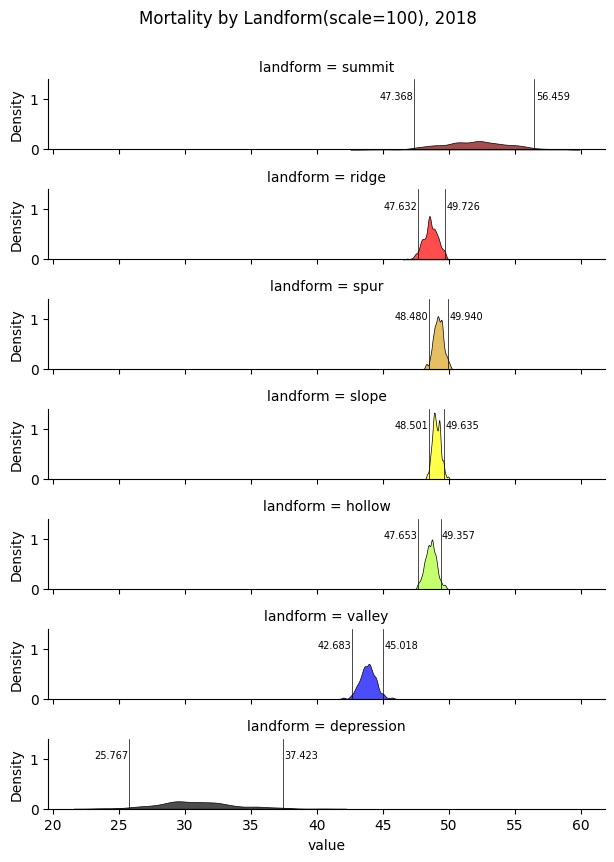

In [377]:
quasi_ridge_plot_w_hdi(obs_df, y, scale)

100%|██████████| 5/5 [02:42<00:00, 32.46s/it]


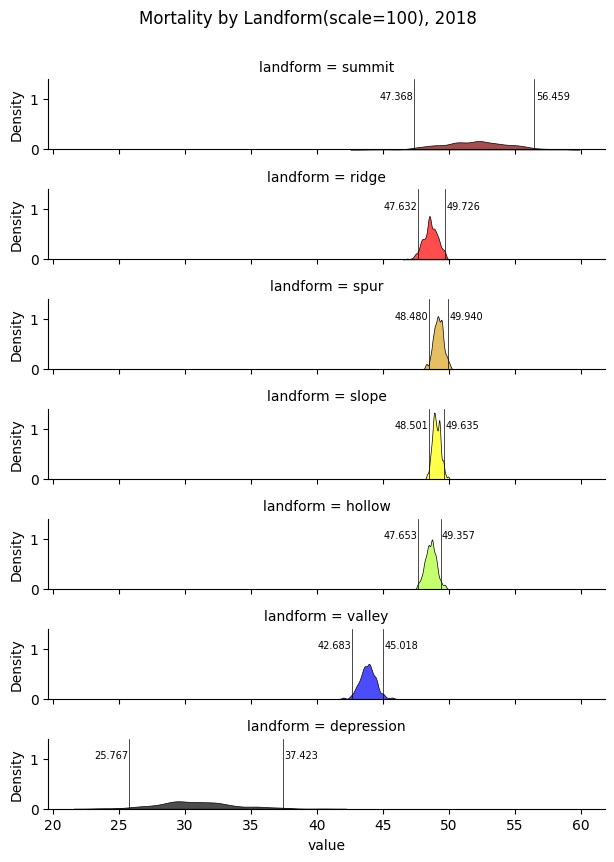

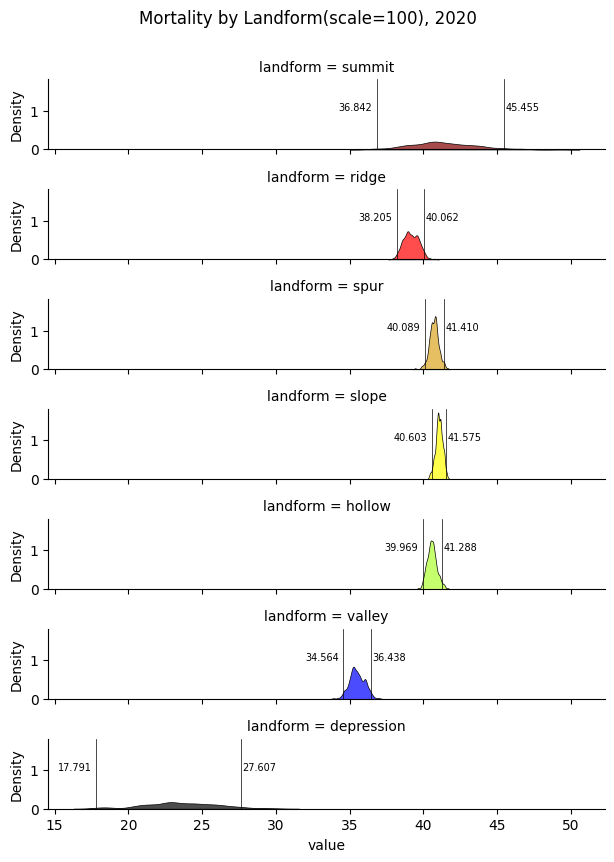

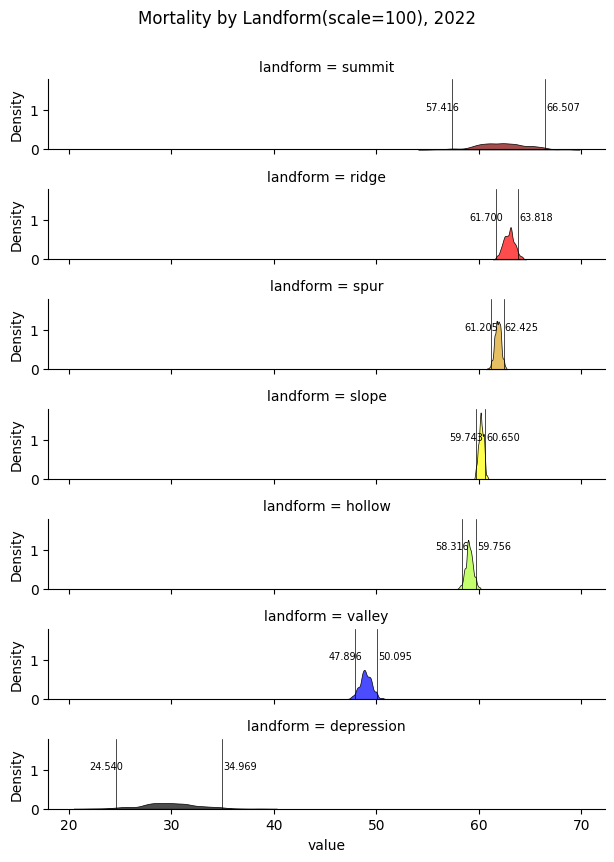

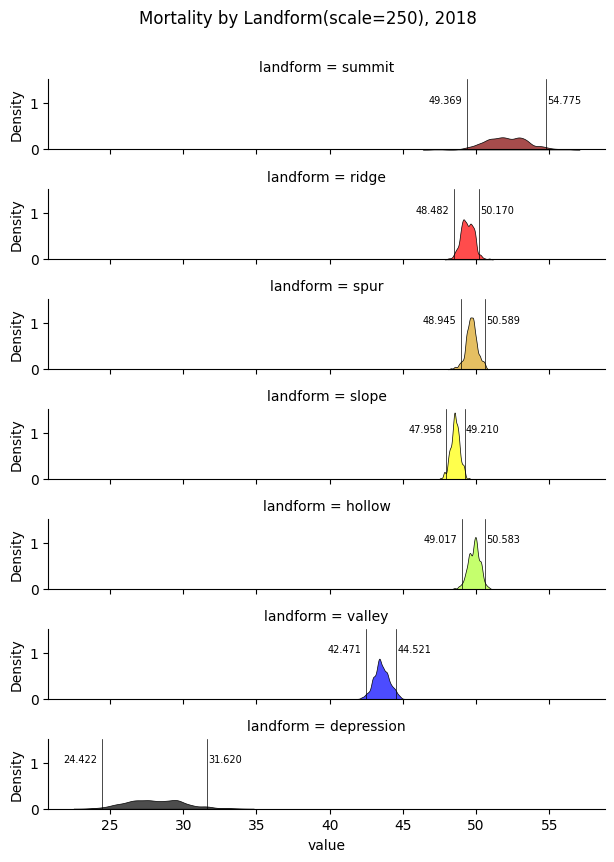

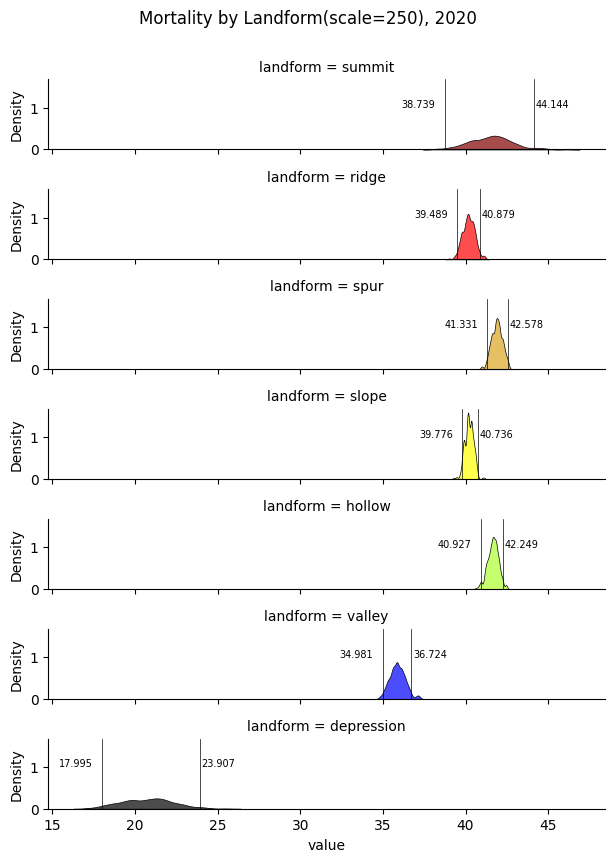

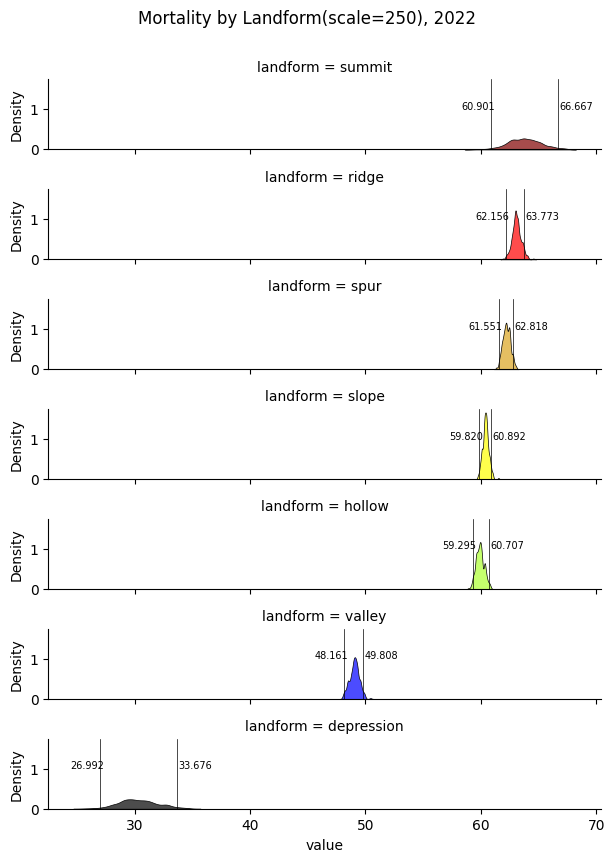

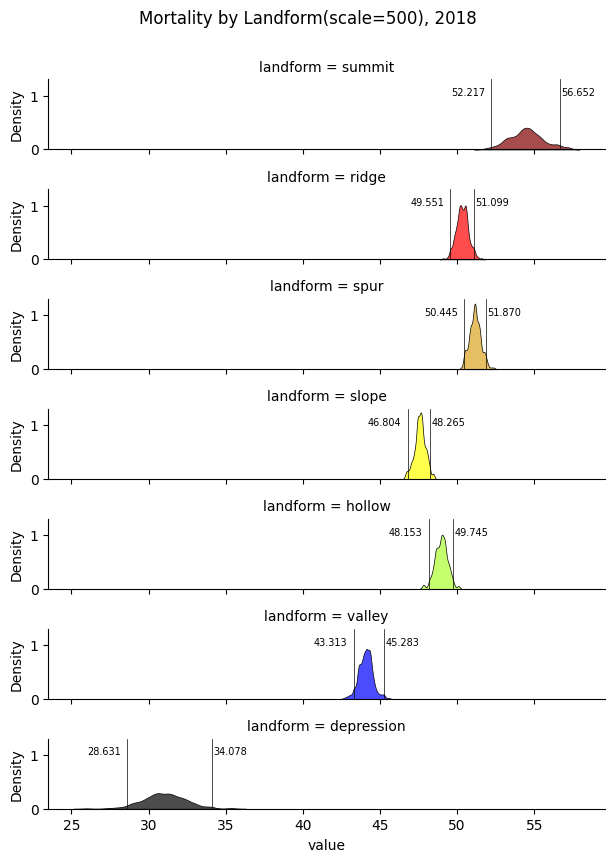

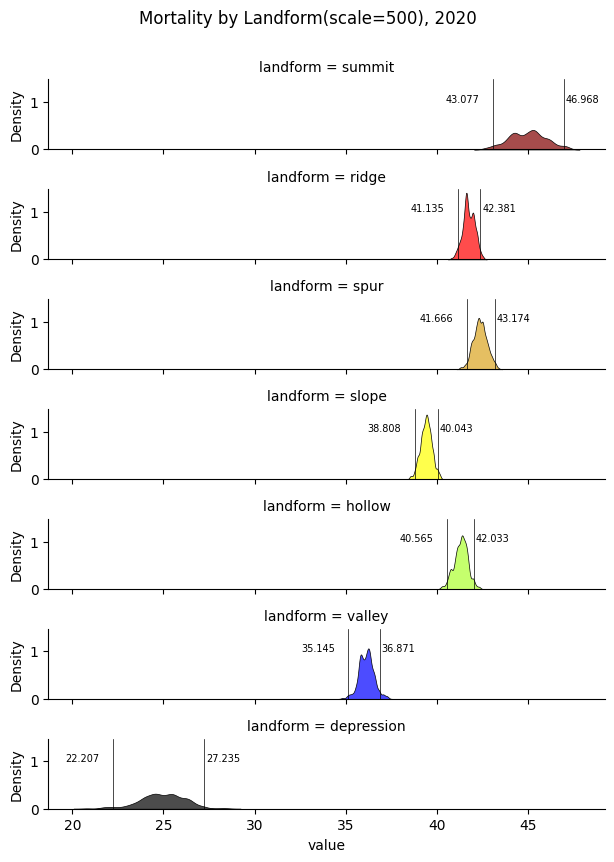

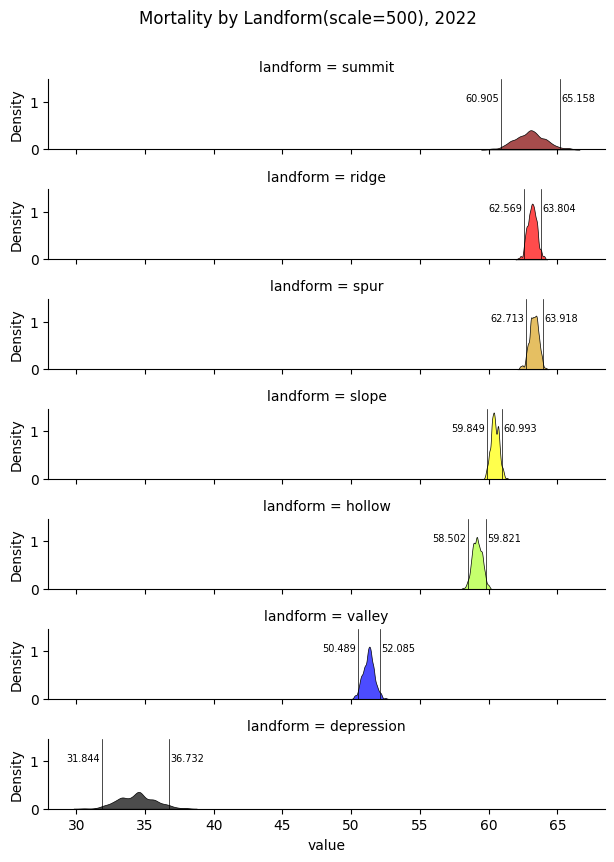

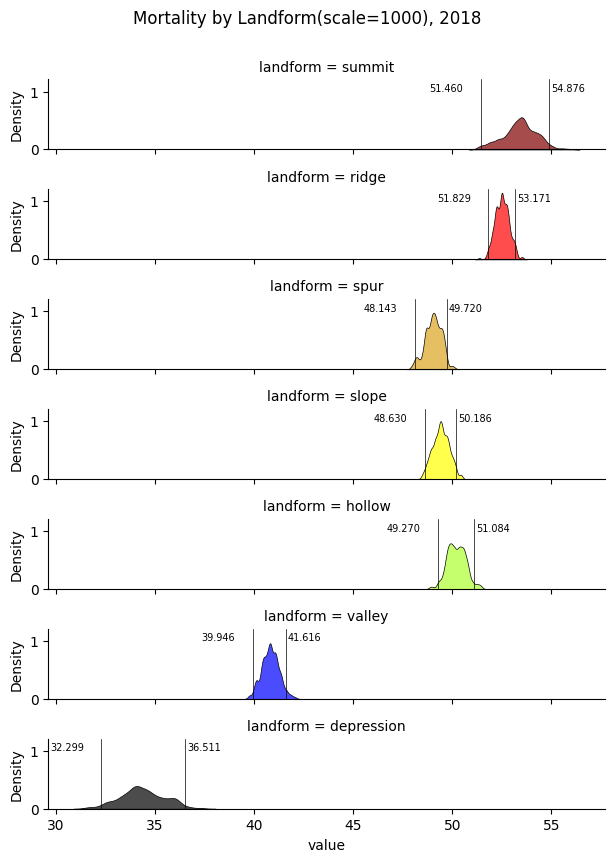

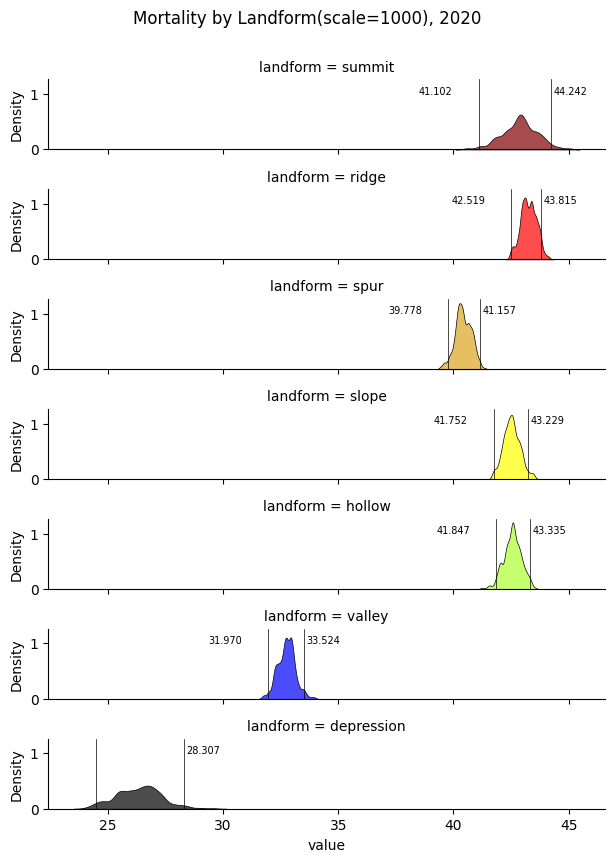

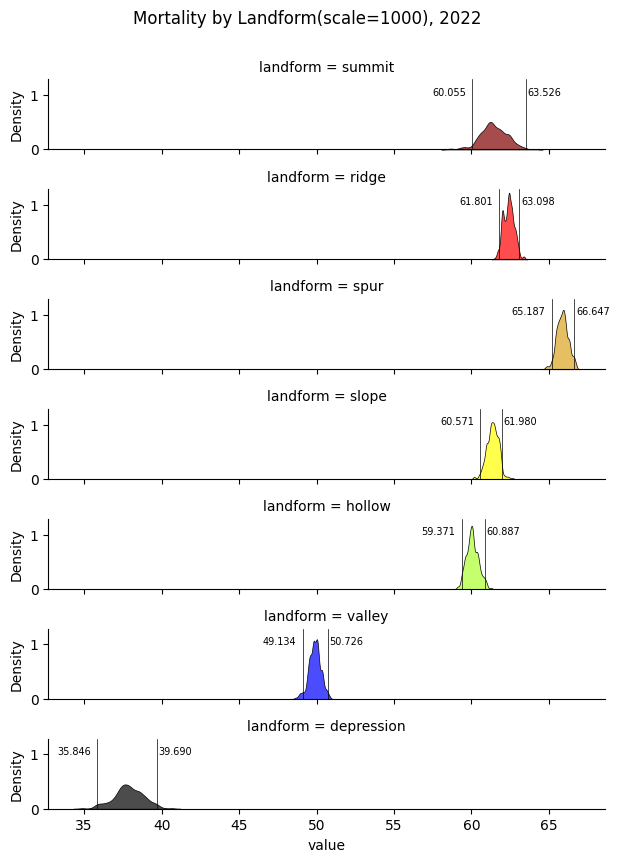

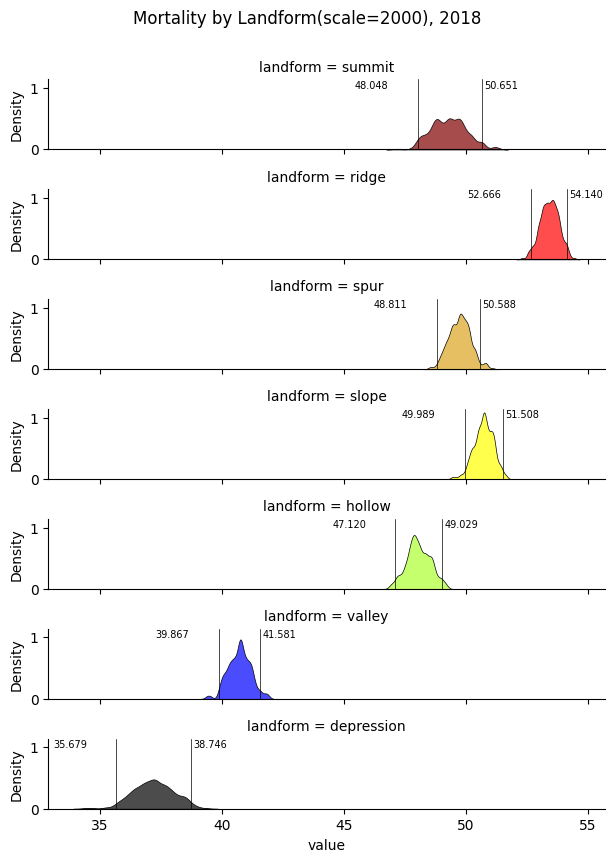

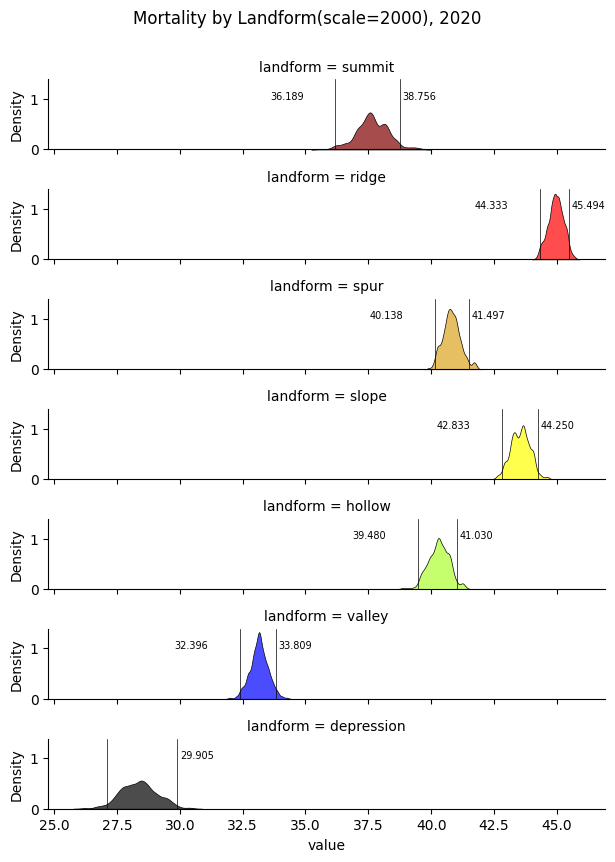

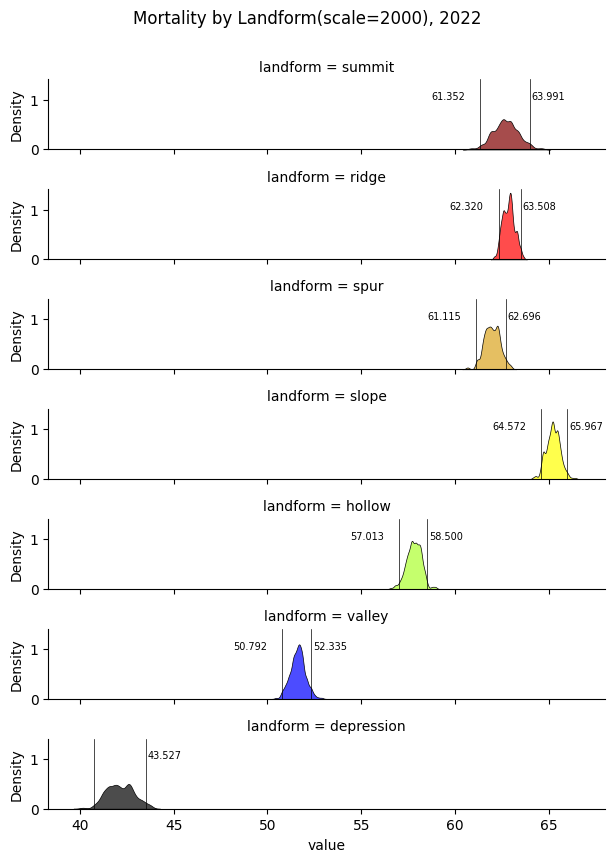

In [384]:
years = ['2018', '2020', '2022']
scales = [c.split('_')[-1] for c in sample_df.columns if 'geomorph_' in c]
for scale in tqdm(scales):
    for y in years:
        lf_obs = get_landform_obs(y, scale)
        obs_df = pd.DataFrame.from_dict(lf_obs)
        quasi_ridge_plot_w_hdi(obs_df, y, scale)

## Test to see how much landform explains differences in treatments.

In [562]:
def get_counts(y, scale, treatments):
    '''
    Returns dict of landform observations for year, y, and scale and treatments.
    Remember, an observation is a percentage dead of a simulated population.
    '''
    # get landforms
    landforms = sample_df[f'geomorph_{scale}'].unique().tolist()
    landforms.sort()
    
    # dict mapping codes to meanings
    tr_codes = {
        'unburned | unburned': 0 ,
        'unburned | high': 3 ,
        'high | unburned': 12 ,
        'high | high': 15
    }
    
    # dict mapping landform codes to meanings
    lf_codes = {
        1 : 'flat',
        2 : 'summit',
        3 : 'ridge',
        4 : 'shoulder',
        5 : 'spur',
        6 : 'slope',
        7 : 'hollow',
        8 : 'footslope',
        9 : 'valley',
        10: 'depression'
    }
    
    # columns with geomorphons of desired scale
    gm_col = [c for c in sample_df.columns if f'geomorph_{scale}' in c][0]
    
    outer_dict = {}
    for (t_, t) in [(tr_codes[t], t) for t in treatments]:
        inner_dict = {}
        for l in landforms:
            # get crowns of correct landform, treatment and year, put count into dict
            lf = sample_df[(sample_df[gm_col] == l) & (sample_df.treatment == t_)][f'sample_{y}'].values
            inner_dict[lf_codes[l]] = len(lf)

        outer_dict[t] = inner_dict
    counts = pd.DataFrame.from_dict(outer_dict)
    return counts


def get_obs(y, scale, treatments):
    '''
    Returns dict of landform observations for year, y, and scale and treatments.
    Remember, an observation is a percentage dead of a simulated population.
    '''
    # get landforms
    landforms = sample_df[f'geomorph_{scale}'].unique().tolist()
    landforms.sort()
    
    # dict mapping codes to meanings
    tr_codes = {
        'unburned | unburned': 0 ,
        'unburned | high': 3 ,
        'high | unburned': 12 ,
        'high | high': 15
    }
    
    # dict mapping landform codes to meanings
    lf_codes = {
        1 : 'flat',
        2 : 'summit',
        3 : 'ridge',
        4 : 'shoulder',
        5 : 'spur',
        6 : 'slope',
        7 : 'hollow',
        8 : 'footslope',
        9 : 'valley',
        10: 'depression'
    }
    
    # columns with geomorphons of desired scale
    gm_col = [c for c in sample_df.columns if f'geomorph_{scale}' in c][0]
    
    # get observations for each landform
    outer_list = []
    outer_dict = {}
    for (t_, t) in [(tr_codes[t], t) for t in treatments]:
        inner_list = []
        inner_dict = {}
        for l in landforms:
            # get crowns of correct landform, treatment and year, put count into dict
            lf = sample_df[(sample_df[gm_col] == l) & (sample_df.treatment == t_)][f'sample_{y}'].values
            inner_dict[lf_codes[l]] = len(lf)
            
            # simulate population and calculate percentage dead
            if lf.shape[0] > 0:
                lf = np.stack(lf)
                
                results = Parallel(n_jobs=n_jobs)(
                delayed(get_dead_percentages)(lf, i)
                for i
                in range(lf.shape[1])
                )
                
                df = pd.DataFrame.from_dict(results)
                df['treatment'] = t
                df['landform'] = lf_codes[l]
                df.columns = ['percent dead', 'treatment', 'landform']
                
                inner_list.append(df)
        outer_dict[t] = inner_dict
        outer_list.append(pd.concat(inner_list))
    counts = pd.DataFrame.from_dict(outer_dict)
    df = pd.concat(outer_list)
                
                
    return df, counts



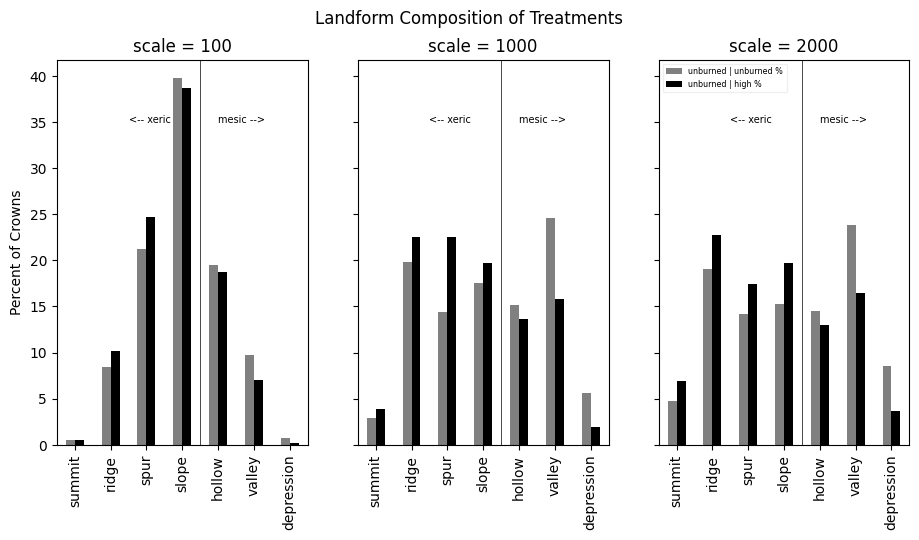

In [627]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(11, 5))
for i, scale in enumerate([100, 1000, 2000]):
    counts = get_counts(2018, scale, ['unburned | unburned', 'unburned | high'])

    for col in counts:
        counts[f'{col} %'] = 100 * counts[col] / counts[col].sum()
    
    ax = axs[i]
    counts[['unburned | unburned %', 'unburned | high %']].plot.bar(ax=ax, color=['grey', 'k'])
    ax.set_title(f'scale = {scale}')
    ax.axvline(3.5, lw=0.5, color='k')
    ax.annotate(f'<-- xeric', (1.5, 35), fontsize=7)
    ax.annotate(f'mesic -->', (4, 35), fontsize=7)
    if i == 2:
        ax.legend(loc='upper left', fancybox=True, framealpha=0.3, fontsize='xx-small')
    else:
        ax.get_legend().remove()
        
    if i == 0:
        ax.set_ylabel('Percent of Crowns')

plt.suptitle('Landform Composition of Treatments')
plt.savefig(img_dir / 'unburned_treatments_landform_barplot.png')

unburned | unburned does seem to be a bit more skewed towards more xeric landforms (above). But controlling for landform does not make them the same at all (below).

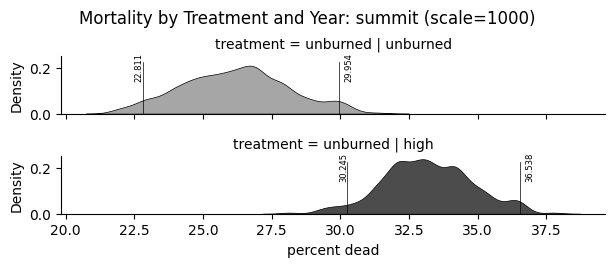

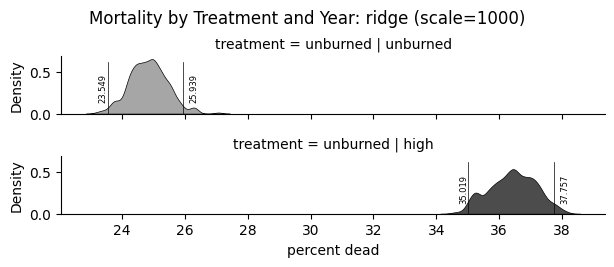

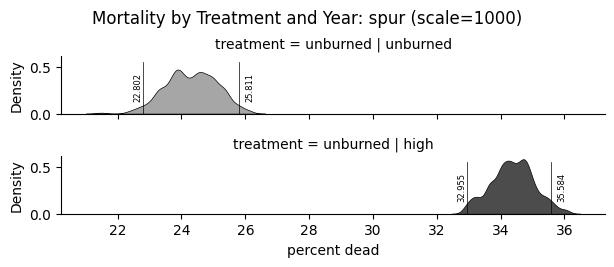

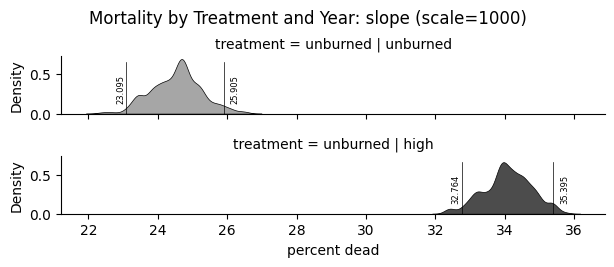

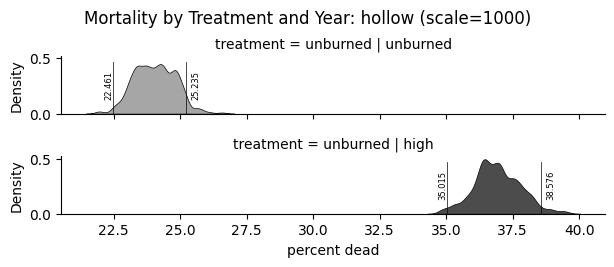

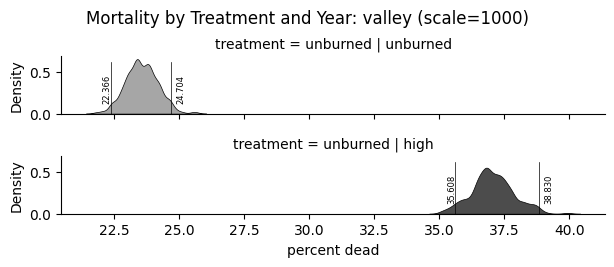

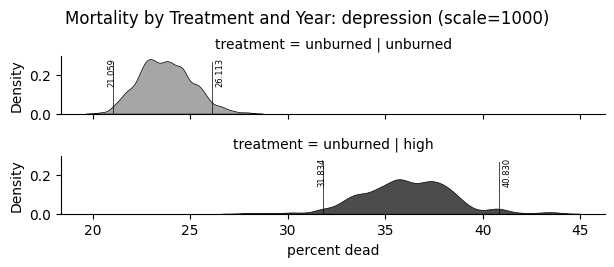

In [640]:
scale = 1000
obs, _ = get_obs(2018, scale, ['unburned | unburned', 'unburned | high'])

lf_codes = {
        1 : 'flat',
        2 : 'summit',
        3 : 'ridge',
        4 : 'shoulder',
        5 : 'spur',
        6 : 'slope',
        7 : 'hollow',
        8 : 'footslope',
        9 : 'valley',
        10: 'depression'
    }
for lf in lf_codes.values():
        obs_df = obs.loc[obs.landform == lf, ['percent dead', 'treatment']]
        d = {'color': ['grey', 'k']}
        if len(obs_df) == 0:
                continue

        rp = sns.FacetGrid(obs_df, row='treatment', hue='treatment', hue_kws=d, aspect=5, height=1.25)

        rp.map(sns.kdeplot, 'percent dead', clip_on=False,
                shade=True, edgecolor='k', alpha=0.7, lw=0.5, bw=.2)

        axes = rp.axes.flatten()
        for ax in axes:
                col = ax.title.get_text().split(' = ')[-1]
                low, high = get_hdi(obs_df[obs_df.treatment == col], 'percent dead')
                ax.axvline(low, ymax=0.9, lw=0.5, color='k')
                ax.axvline(high, ymax=0.9, lw=0.5, color='k')
                ax.annotate(f'{low:.3f}', (low - 0.3, 0.15), fontsize=6, rotation=90)
                ax.annotate(f'{high:.3f}', (high + 0.2, 0.15), fontsize=6, rotation=90)

        #plt.legend(loc='upper right', bbox_to_anchor=(1, 7.6))
        #rp.fig.subplots_adjust(top=1)
        rp.fig.suptitle(f'Mortality by Treatment and Year: {lf} (scale={scale})', y=1.05)   
        #rp.fig.savefig(img_dir / f'{save_template}_{y}.png')   
    


In [691]:
# find the distance between the burned and unburned groups component treatments
hdi_dict = {}
for col in ['unburned | unburned', 'unburned | high', 'high | unburned', 'high | high']:
    low, high = get_hdi(treatment_obs_df[treatment_obs_df.year == '2018'], col)
    hdi_dict[col] = {
        'low': low, 
        'high': high
    }

unburned_diff = hdi_dict['unburned | high']['low'] - hdi_dict['unburned | unburned']['high']
burned_diff = hdi_dict['high | unburned']['low'] - hdi_dict['high | high']['high']


# get the distance between groups in each component treatment
lf_hdi_dict = {}
for lf in lf_codes.values():
    lf_hdi_dict[lf] = {}
    for tr in ['unburned | unburned', 'unburned | high', 'high | unburned', 'high | high']:
        obs_df = obs.loc[(obs.landform == lf) & (obs.treatment == tr), ['percent dead', 'treatment']]
        if len(obs_df) > 0 :
            low, high = get_hdi(obs_df, 'percent dead')
            lf_hdi_dict[lf][tr] = {
                'low': low,
                'high': high
            }

    lf_hdi_dict[lf] = pd.DataFrame.from_dict(lf_hdi_dict[lf])
    if len(lf_hdi_dict[lf]) == 0:
        del lf_hdi_dict[lf]
          
grouped_hdi_diffs = pd.DataFrame.from_dict({
    'unburned': {
        lf:
        lf_hdi_dict[lf].loc['low', 'unburned | high'] -
        lf_hdi_dict[lf].loc['high', 'unburned | unburned']
        for lf in lf_hdi_dict.keys()}
})

diff = unburned_diff - grouped_hdi_diffs.unburned.mean()
print(f'Change in distance between HDIs by controlling for group is {diff:.3f}\n or {100 * diff / unburned_diff:.2f}%')


Change in distance between HDIs by controlling for group is 2.812
 or 28.34%


Controlling for landform does explain some of the difference for the initially burned sites (se below).

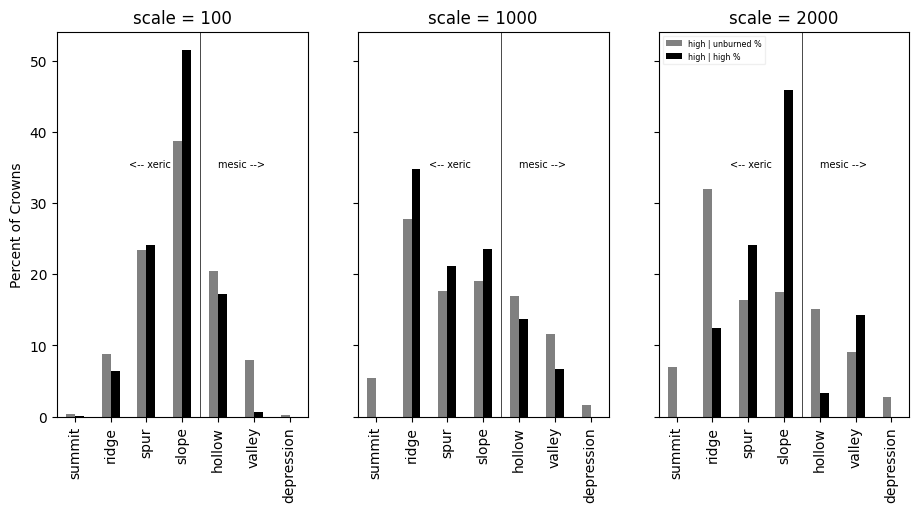

In [628]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(11, 5))
for i, scale in enumerate([100, 1000, 2000]):
    counts = get_counts(2018, scale, ['high | unburned', 'high | high'])

    for col in counts:
        counts[f'{col} %'] = 100 * counts[col] / counts[col].sum()
    
    ax = axs[i]
    counts[['high | unburned %', 'high | high %']].plot.bar(ax=ax, color=['grey', 'k'])
    ax.set_title(f'scale = {scale}')
    ax.axvline(3.5, lw=0.5, color='k')
    ax.annotate(f'<-- xeric', (1.5, 35), fontsize=7)
    ax.annotate(f'mesic -->', (4, 35), fontsize=7)
    if i == 2:
        ax.legend(loc='upper left', fancybox=True, framealpha=0.3, fontsize='xx-small')
    else:
        ax.get_legend().remove()
        
    if i == 0:
        ax.set_ylabel('Percent of Crowns')
        
plt.savefig(img_dir / 'burned_treatments_landform_barplot.png')

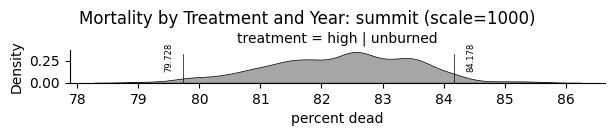

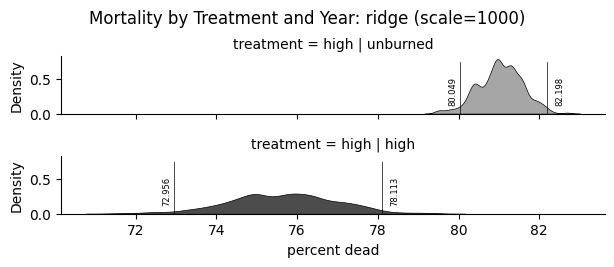

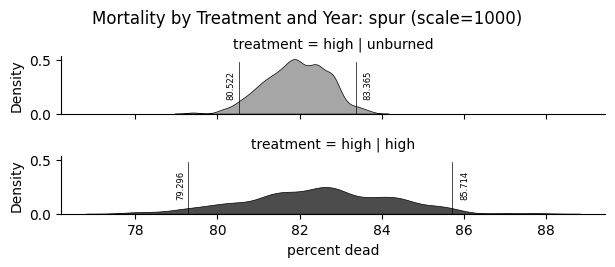

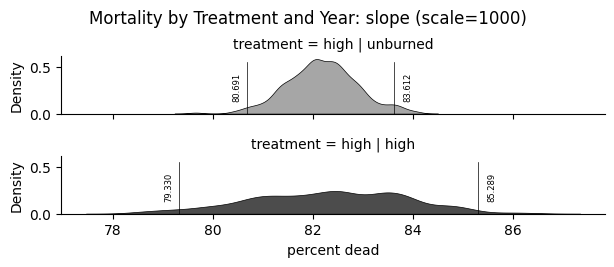

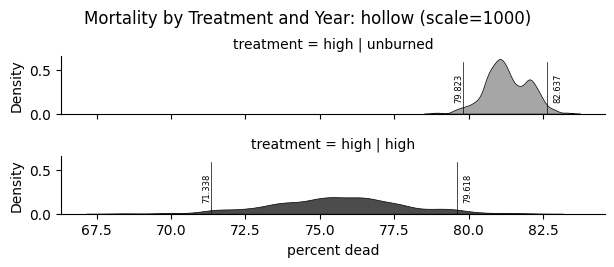

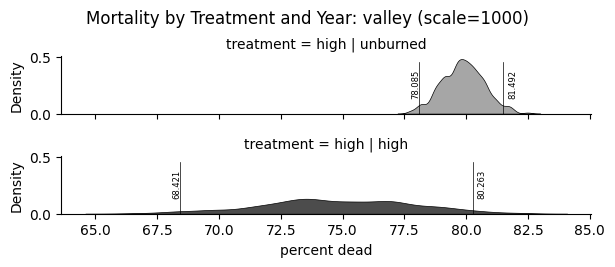

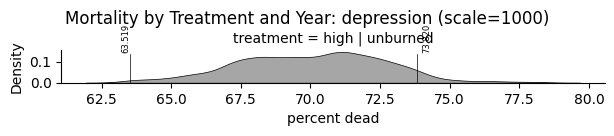

In [693]:
scale = 1000
obs, _ = get_obs(2018, scale, ['high | unburned', 'high | high'])

lf_codes = {
        1 : 'flat',
        2 : 'summit',
        3 : 'ridge',
        4 : 'shoulder',
        5 : 'spur',
        6 : 'slope',
        7 : 'hollow',
        8 : 'footslope',
        9 : 'valley',
        10: 'depression'
    }
for lf in lf_codes.values():
        obs_df = obs.loc[obs.landform == lf, ['percent dead', 'treatment']]
        d = {'color': ['grey', 'k']}
        if len(obs_df) == 0:
                continue

        rp = sns.FacetGrid(obs_df, row='treatment', hue='treatment', hue_kws=d, aspect=5, height=1.25)

        rp.map(sns.kdeplot, 'percent dead', clip_on=False,
                shade=True, edgecolor='k', alpha=0.7, lw=0.5, bw=.2)

        axes = rp.axes.flatten()
        for ax in axes:
                col = ax.title.get_text().split(' = ')[-1]
                low, high = get_hdi(obs_df[obs_df.treatment == col], 'percent dead')
                ax.axvline(low, ymax=0.9, lw=0.5, color='k')
                ax.axvline(high, ymax=0.9, lw=0.5, color='k')
                ax.annotate(f'{low:.3f}', (low - 0.3, 0.15), fontsize=6, rotation=90)
                ax.annotate(f'{high:.3f}', (high + 0.2, 0.15), fontsize=6, rotation=90)

        #plt.legend(loc='upper right', bbox_to_anchor=(1, 7.6))
        #rp.fig.subplots_adjust(top=1)
        rp.fig.suptitle(f'Mortality by Treatment and Year: {lf} (scale={scale})', y=1.05)   
        #rp.fig.savefig(img_dir / f'{save_template}_{y}.png')   
    

In [703]:
# find the distance between the burned and unburned groups component treatments
hdi_dict = {}
for col in ['unburned | unburned', 'unburned | high', 'high | unburned', 'high | high']:
    low, high = get_hdi(treatment_obs_df[treatment_obs_df.year == '2018'], col)
    hdi_dict[col] = {
        'low': low, 
        'high': high
    }

unburned_diff = hdi_dict['unburned | high']['low'] - hdi_dict['unburned | unburned']['high']
burned_diff = hdi_dict['high | unburned']['low'] - hdi_dict['high | high']['high']


# get the distance between groups in each component treatment
lf_hdi_dict = {}
for lf in lf_codes.values():
    lf_hdi_dict[lf] = {}
    for tr in ['unburned | unburned', 'unburned | high', 'high | unburned', 'high | high']:
        obs_df = obs.loc[(obs.landform == lf) & (obs.treatment == tr), ['percent dead', 'treatment']]
        if len(obs_df) > 0 :
            low, high = get_hdi(obs_df, 'percent dead')
            lf_hdi_dict[lf][tr] = {
                'low': low,
                'high': high
            }

    lf_hdi_dict[lf] = pd.DataFrame.from_dict(lf_hdi_dict[lf])
    if len(lf_hdi_dict[lf]) == 0:
        del lf_hdi_dict[lf]
        
# drop entroies with out both treatments
bad_keys = []
for k in lf_hdi_dict.keys():
    if len(lf_hdi_dict[k].columns.to_list()) <2:
        bad_keys.append(k)
        
for k in bad_keys:
    del lf_hdi_dict[k]

lf_hdi_dict

# find diffs
grouped_hdi_diffs = pd.DataFrame.from_dict({
    'unburned': {
        lf: max(
            lf_hdi_dict[lf].loc['low', 'high | unburned'] -
            lf_hdi_dict[lf].loc['high', 'high | high'],
            0
        )
        for lf in lf_hdi_dict.keys()}
})

diff = unburned_diff - grouped_hdi_diffs.unburned.mean()
print(f'Change in distance between HDIs by controlling for group is {diff:.3f}\n or {100 * diff / unburned_diff:.2f}%')

Change in distance between HDIs by controlling for group is 9.495
 or 95.69%


In [702]:
lf_hdi_dict

{'ridge':       high | unburned  high | high
 low         80.048840    72.955975
 high        82.197802    78.113208,
 'spur':       high | unburned  high | high
 low         80.522474    79.296066
 high        83.365348    85.714286,
 'slope':       high | unburned  high | high
 low         80.691129    79.329609
 high        83.612398    85.288641,
 'hollow':       high | unburned  high | high
 low         79.823151    71.337580
 high        82.636656    79.617834,
 'valley':       high | unburned  high | high
 low         78.084606    68.421053
 high        81.492362    80.263158}

In 2018, only the Helena fire had occurred, so `high | unburned` and `high | high` should be equivalent treatments, ...

For treatments that were burned at high intensity (`high | unburned` and `high | high`), landform does appear to contribute to the difference between treatments groups.  Using a scale of 1000, valleys and slopes did not show a significant difference in percentage of crowns that are dead between the  `high | unburned` and `high | high` treatments. For ridges, spurs, and hollows `high | unburned` was significantly higher than `high | high` (These results change somewhat with scale, for instance, when this analysis is performed with scale=2000, the difference in hollows becomes insignificant).  Summits and depressions that were burned at high intensity in the Helena fire did not burn again in the Monument fire, thus all summits and depressions that were burned at high intensity at this point belong to the `high | unburned` treatment.  The exact relationships between landforms and at different scales and their contributions to the difference between the treatment groups is quite complex, and I did not attempt to completely decipher it.